In [1]:
### Print not only the last line in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Make the scroll window slightly larger
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 30em; }</style>"))

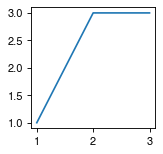

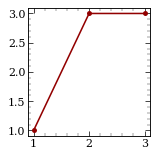

In [2]:
import sys
import os
# top_path = '..'
# if top_path not in sys.path:
#     sys.path.append(top_path)

# coffea_path = '/afs/cern.ch/user/a/anpotreb/top/JERC/coffea/'
# if coffea_path not in sys.path:
#     sys.path.insert(0,coffea_path)
    
# ak_path = '/afs/cern.ch/user/a/anpotreb/top/JERC/local-packages/'

# if ak_path not in sys.path:
#     sys.path.insert(0,ak_path)
    
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from coffea import util
from helpers import hist_mult, hist_add
from plotters.pltStyle import pltStyle
from correction_fitter import correction_fitter
import mplhep as hep
pltStyle('hep')

#### some newer versions of pyplot and mplhep, aren't good friends with jupyter
#### To make the plots be formatted directly well, we need to make a dummy plot and rerun the import
### (a very silly solution)
plt.figure(num=None, figsize=(2, 2), dpi=80)
plt.plot([1,2,3],[1,3,3])
import matplotlib.pyplot as plt
pltStyle('hep', font_frac=1.05) #
plt.rcParams['legend.labelspacing']*0.45
plt.rcParams['figure.subplot.right'] = 0.96
# from collections.abc import Iterable
# %matplotlib notebook 
# %matplotlib notebook
1;

In [3]:
from helpers import sum_neg_pos_eta, rebin_hist, get_xsec_dict, get_flavor_antiflavor_list
from JetEtaBins import JetEtaBins, PtBins

from fileNames.available_datasets import dataset_dictionary

from uncertainty_helpers import get_output, sum_output, combine_flavors, get_spline, FlavorFractions, create_data_HerPy_differences, get_spline_smooth
from uncertainty_plotters import plot_Efractions, plot_Efractions_ratio, plot_ratio_comparisons_samples, plot_HerPydiff, plot_uncertainty, plot_uncertainty_antiflav, legend_dict_q_vs_qbar, plot_Rref

from uncertainty_helpers import read_corrections, ptmin_global, ptmax_global
# from uncertainty_helpers import get_evaluator_limits, get_evaluator_limits_all_flav
from RatioPlotFitRes import RatioPlotFitRes, CorrectionEvaluator, get_uncertainty
from scipy.interpolate import RegularGridInterpolator 

# from common_binning import JERC_Constants

Welcome to JupyROOT 6.28/04


In [4]:
use_corrections = 'simfit'  ## 'J' for QCD, 'T' for ttbar 'ratio' for the simultaneous fit of R(Herwig)-R(Pythia) -> not really a `ratio` but a difference, 'simfit' for the simfit of the corrections### If to include unmatched in calculating the uncertainties with seperate fits and
### include them in the flavor fraction plots.
### If False, unmatched are ignored
include_unmatched = False
combine_antiflavour = True
combine_antiflavour_txt = '_split_antiflav' if not combine_antiflavour else ''
add_composed_flav = True # if to also provide uncertainty for q as ud+s
rerun_fits = False

eta_binning  = "Summer20Flavor"  ### HCalPart, CoarseCalo, CaloTowers, one_bin, Summer20Flavor;       
                         ### HCalPart: bin in HCal sectors, CaloTowers: the standard JERC binning,
                         ### CoarseCalo: like 'CaloTowers' but many bins united;

In [5]:
jeteta_bins = JetEtaBins(eta_binning, absolute=True)
pt_bins = PtBins("MC_truth")
eta_binning_str = '_'+eta_binning if eta_binning != "HCalPart" else ''

In [6]:
if not combine_antiflavour and use_corrections == 'ratio':
    raise ValueError("Ratio results are not yet supported for the flavor/antiflavor uncertainty")

### Sum together all the different flavors and
### Get the splines of the flavor fractions

In [7]:
from save_json import save_json_fractions, save_fractions_root

True

True

True

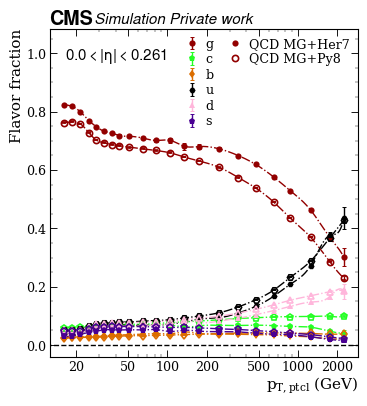

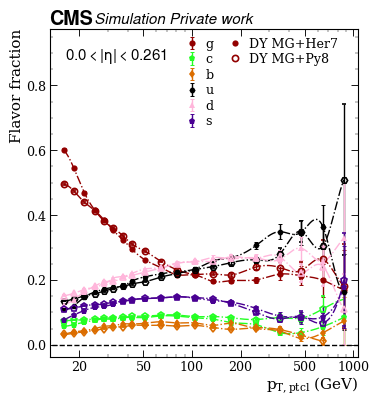

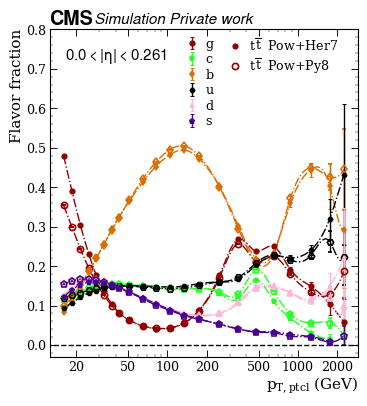

In [8]:
from fileNames.available_datasets import legend_labels

eta_idx = jeteta_bins.get_bin_idx(0)
ndraw = jeteta_bins.nbins if include_unmatched==True else 1
if not combine_antiflavour and eta_binning == "HCalPart":
    ndraw = jeteta_bins.nbins
samples = ['QCD', 'DY', 'TTBAR']
Her_samples = ['QCD-MG-Her', 'DY-MG-Her', 'Herwig-TTBAR']
Py_samples = ['QCD-MG-Py', 'DY-MG-Py', 'Pythia-TTBAR']

Her_legends = ['QCD MG+Her7', 'DY MG+Her7', legend_labels["ttbar"]["lab"]+' Pow+Her7']
Py_legends = ['QCD MG+Py8', 'DY MG+Py8', legend_labels["ttbar"]["lab"]+' Pow+Py8']

if include_unmatched==True:
    Her_samples+=['QCD-Py']
    Her_legends+=['QCD Py8']
    Py_samples+=['QCD-MG-Py']
    Py_legends+=['QCD MG+Py8']
    samples+=['QCD_stand']
# samples = ['QCD', 'DY', 'TTBAR']
# Her_samples = ['_QCD-MG-Py_3rd_jet', '_DY-MG-Her', '_Herwig-TTBAR']
# Py_samples = ['_QCD-Py_3rd_jet', '_DY-MG-Py', '_Pythia-TTBAR'] #_sel_67ac6c3

qfrac_dict = {}
qfrac_var_dict = {}
qfrac_spline_dict = {}
# qfrac_spline_dict2 = {}
qfrac_spline_dict2D = {}
legend_labels = []
flavors = ['g', 'c', 'b', 'u', 'd', 's', 'unmatched'] if include_unmatched==True else ['g', 'c', 'b', 'u', 'd', 's']
# flavors = ['g', 'c', 'b', 'ud', 's', 'unmatched'] if include_unmatched==True else ['g', 'c', 'b', 'ud', 's']
# flavors = ['g', 'c', 'b', 'ud', 's', 'unmatched'] if include_unmatched==True else ['b_gluon_splitting', 'b_prompt', 'c_gluon_splitting', 'c_prompt','g', 'ud', 's']
# flavors = ['g', 'c', 'b', 'ud', 's', 'unmatched'] if include_unmatched==True else ['b_gluon_splitting', 'b_prompt','g', 'ud', 's']
# flavors = ['g', 'cs', 'b', 'ud', 'unmatched']
if not combine_antiflavour:
    flavors_orig = flavors
    flavors = get_flavor_antiflavor_list(flavors)
    flavors_orig = [flav for flav in flavors_orig if not flav == 'g']
#     flavors_orig.pop('g')
    
flavors_to_obtain = flavors+['all'] if include_unmatched==True else flavors
    
saveplot = include_unmatched if combine_antiflavour else True

for ii in range(len(samples)):
# for ii in range(1):
    sampHer = Her_samples[ii]
    sampPy = Py_samples[ii]
    legenddict = {sampPy:Py_legends[ii], sampHer:Her_legends[ii] }
    samp = samples[ii]
    sample_plot = {}
    hists_rebinned_dict = {}
    if 'QCD_stand' in samp:
        ratio_title="Py8/MG+Py8"
    else:
        ratio_title="Her7/Py8"
    
    for sample in [sampHer, sampPy]:
#     for sample in ['QCD-Py_genwt', 'QCD-MG-Py', 'QCD-Py']:
        output = get_output(sample)
        file_dict, legend_label = get_xsec_dict(sample, dataset_dictionary)
        output = sum_output(output, sample, file_dict)
        hists = combine_flavors(output, flavors_to_obtain, sumeta=False, combine_antiflavour=combine_antiflavour)
#         check_bins(hists[flavors[0]], jeteta_bins, pt_bins)
            
        hists_rebinned = {flav: rebin_hist(sum_neg_pos_eta(hists[flav]), 'jeteta', jeteta_bins.edges) for flav in hists.keys() }
        if include_unmatched==False: #recalculate the all
            hists_rebinned['all'] = sum([hists_rebinned[flav] for flav in flavors])
        hists_rebinned_dict[sample] = hists_rebinned
        hists_vals = {}
        for flav in hists_rebinned.keys():
            vals = hists_rebinned[flav].values().copy()
            vals[vals==0] = np.nan
            hists_vals[flav] = vals
        if combine_antiflavour:
            qfracs = {flav: hists_vals[flav]/hists_vals['all'] for flav in flavors}
            qfrac_var_all = hists_rebinned['all'].variances()/hists_vals['all']**2
            qfrac_var = {}
            for flav in flavors:
                qfrac_var[flav] = qfracs[flav]**2*(hists_rebinned[flav].variances()/hists_vals[flav]**2 + qfrac_var_all**2)
        else:
            qfracs = {}
            qfrac_var = {}
            for flav in flavors_orig:
                aflav = flav+'bar'
                hist_all = hists_vals[flav]+hists_vals[aflav]
                qfrac_var_all = (hists_rebinned[flav]+hists_rebinned[aflav]).variances()/hist_all**2
                for flavii in [flav, aflav]:
                    qfracs[flavii] = hists_vals[flavii]/hist_all
#                     qfracs[aflav] = hists_vals[aflav]/hist_all
                    qfrac_var[flavii] = qfracs[flavii]**2*(hists_rebinned[flavii].variances()/hists_vals[flavii]**2 + qfrac_var_all**2)
                
#         qfracs_var = {flav: hists_rebinned[flav].variances()/hists_rebinned['all'].variances() for flav in flavors}
        Efrac_splines = {key: 
                         np.array([get_spline_smooth(qfracs[key][:,eta_idx], qfracs[key][:,eta_idx], pt_bins, s=0) 
                          for eta_idx in range(jeteta_bins.nbins)
                         ])
                        for key in qfracs.keys()
                        }
        Efrac_2Dsplines = {key: RegularGridInterpolator((np.log10(pt_bins.centres), jeteta_bins.centres), qfracs[key], fill_value=None) 
                          for key in qfracs.keys()}
        
#         yval = qfracs['g'][:,0]

#         Efrac_fit_dict[sample] = Efrac_fits
        qfrac_dict[sample] = qfracs
        qfrac_var_dict[sample] = qfrac_var
        zero_spline = get_spline(np.array([1e-15]*pt_bins.nbins), pt_bins)
        if add_composed_flav:
            Efrac_splines['q'] = np.array([zero_spline]*jeteta_bins.nbins)
            Efrac_splines['ud'] = np.array([zero_spline]*jeteta_bins.nbins)
            if not combine_antiflavour:
                Efrac_splines['qbar'] = np.array([zero_spline]*jeteta_bins.nbins)
        qfrac_spline_dict[sample] = FlavorFractions(Efrac_splines, eta_binning) #Efrac_splines #Efrac_2Dsplines
#         qfrac_spline_dict2[sample] = Efrac_splines
        
        qfrac_spline_dict2D[sample] = Efrac_2Dsplines
        sample_plot[sample] = [qfracs, qfrac_var, Efrac_splines, Efrac_2Dsplines]
        legend_labels.append(legend_label) if sample != 'QCD-Py_genwt' else legend_labels.append(legend_label+', weights')

    for eta_idx in range(ndraw):
#     for eta_idx in range(2):
        plot_Efractions(sample_plot, eta_idx, jeteta_bins, pt_bins, legenddict=legenddict, saveplot=saveplot)
        if combine_antiflavour:
            True
#             plot_Efractions_ratio(sample_plot, [sampPy, sampHer], eta_idx, jeteta_bins, pt_bins, legenddict=legenddict, saveplot=saveplot,
#                                  ratio_title=ratio_title)
        else:
            sample_plot_new = {}
#                 aflav = flav+'bar'
            for key in sample_plot:
                lis = []
                for var in sample_plot[key]:
#                     sample_plot[key]
                    lis.append({flav:var[flav]  for flav in flavors_orig})
                sample_plot_new[key] = lis
            fig_name = 'fig/fractions/fraction_q_vs_qbar_'+jeteta_bins.idx2str(eta_idx)+"_"+"_".join([sampPy, sampHer])
            plot_Efractions_ratio(sample_plot_new, [sampPy, sampHer], eta_idx, jeteta_bins, pt_bins, legenddict=legenddict, legenddict2=legend_dict_q_vs_qbar,
                                  saveplot=saveplot, ratio_lim=(0.8,1.2), legend1_loc=(0.02,0.88), )

#             for flav in flavors_orig:
#                 sample_plot_new = {}
#                 aflav = flav+'bar'
#                 for key in sample_plot:
# #                     sample_plot[key]
#                     sample_plot_new[key] = [{flav:var[flav], aflav: var[aflav]} for var in sample_plot[key]]
#             # flavors_orig
#             # flavors_orig = [flav for flav in flavors_orig if not flav == 'g']
#                 plot_Efractions_ratio_antiflav(sample_plot_new, [sampPy, sampHer], eta_idx, jeteta_bins, pt_bins, legenddict=legenddict, saveplot=saveplot)
#     plot_spectra(hists_rebinned_dict, legend_labels, 'all', eta_idx, jeteta_bins, pt_bins, saveplot=True, plotvspt=True)
#         correction_dict[sample] = {flav: read_corrections(sample, flav) for flav in flavors}
    if saveplot:
        json_filename = 'out_txt/flavor_fractions_'+'_'.join([sampHer, sampPy])+eta_binning_str+'.json'
        save_json_fractions(sample_plot, pt_bins, jeteta_bins, json_filename)
        root_filename = 'out_txt/flavor_fractions_'+'_'.join([sampHer, sampPy])+eta_binning_str+'.root'
        save_fractions_root(sample_plot, pt_bins, jeteta_bins, root_filename)

if add_composed_flav:
    flavors=flavors[:3]+['q']+['ud']+flavors[3:] if combine_antiflavour else flavors+['q', 'qbar'] + ['u', 'd', 'ubar', 'dbar']

In [9]:
# filename = 'out_txt/flavor_fractions_Herwig-TTBAR_Pythia-TTBAR.json'
# with open(filename, 'r') as json_file:
# #     li = json_file.readlines()
#     data = json.load(json_file)

In [10]:
# from data_tools import read_or_recreate_data, read_or_recreate_data_txt
# from collections.abc import Iterable

In [11]:
# out_txt_path = 'out_txt'

# def read_data4plot(tag, closure=1, path=out_txt_path):
#     '''Read the Mean, MeanStd, Median, MedianStd and RecoPt values of the data with tag `tag`.
#     If closure==1, there is no clusure, otherwise it has to be of the same shape as the data read
#     '''
# #     file_path = f'../out_txt/fit_results_L5_{tag}.json'
# #     with open(file_path, 'r') as json_file:
# #         json_data = json.load(json_file)
    
#     data = read_or_recreate_data(tag, path)['data']

#     if not isinstance(closure, Iterable):
#         closure_tmp = np.array([closure])
#     else:
#         closure_tmp = np.array(closure).copy()
#         closure_tmp[closure_tmp==0] = np.nan
    
#     close = ["Median", "Mean"]
#     for flav in data:
#         for mean_name in close:
#             data[flav][mean_name] = data[flav][mean_name]/closure_tmp #[2:]
#         for typeii in ["MedianStd", "MeanStd", "MeanRecoPt"]:
#             data[flav][typeii] = np.array(data[flav][typeii])

#     return data

In [12]:
# Her_samples # = ['QCD-MG-Her', 'DY-MG-Her', 'Herwig-TTBAR']
# Py_samples
# eta_binning_str
# closure = read_data4plot('_L5_'+'QCD-Py'+eta_binning_str)['all']['Median']

# resp_mean = {}
# resp_std = {}

# for samp in np.concatenate([Her_samples, Py_samples]):
# #     samp += eta_binning_str
#     respii = read_data4plot('_L5_'+samp+eta_binning_str, closure=closure)
#     resp_mean[samp] = {flav: respii[flav]['Median'] for flav in flavors}
#     resp_std[samp] = {flav: respii[flav]['MedianStd'] for flav in flavors}

# qfrac_std_dict = {}
# #     qfrac_var_dict.keys()
# # for samp in qfrac_var_dict.keys():
# #     blah = {} 
# #     for flav in flavors:
# #         blah[flav] = 
# qfrac_std_dict = {samp: {flav: np.sqrt(qfrac_var_dict[samp][flav]) for flav in flavors} for samp in qfrac_var_dict.keys() }

In [13]:
# qfrac_std_dict

In [14]:
# qfrac_std_dict[samp][flav]

In [15]:
# qfrac_var_dict.keys()
# qfrac_std_dict

In [16]:
def hist_sub(hist1, hist2):
#     check_hist_values(hist1, hist2)
    return {key:(hist1[key]-hist2[key]) for key in hist1.keys()}


In [17]:
# resp_mean['QCD-MG-Her'].keys()

In [18]:
# # flavs = ['b', 'g', 'c', 'ud']
# mult = hist_sub(hist_mult(resp_mean['Herwig-TTBAR'], qfrac_dict['DY-MG-Her']), hist_mult(resp_mean['Pythia-TTBAR'], qfrac_dict['DY-MG-Py']))

# std_mult_sq = {}
# for flav in resp_std['Pythia-TTBAR'].keys():
#     qfrac_Py_std = np.sqrt(qfrac_var_dict['DY-MG-Py'][flav])
#     qfrac_Her_std = np.sqrt(qfrac_var_dict['DY-MG-Her'][flav])
#     term = ((resp_mean['Pythia-TTBAR'][flav]*qfrac_Py_std )**2 + (resp_std['Pythia-TTBAR'][flav]*qfrac_dict['DY-MG-Py'][flav])**2 
#           + (resp_mean['Herwig-TTBAR'][flav]*qfrac_Her_std)**2 + (resp_std['Herwig-TTBAR'][flav]*qfrac_dict['DY-MG-Her'][flav])**2)
#     std_mult_sq[flav] = term
    


# sum_resp = np.zeros_like(mult['g'])
# sum_std = np.zeros_like(mult['g'])
# for flav in ['b', 'g', 'c', 'ud']:
#     sum_resp+=mult[flav]
#     sum_std +=  std_mult_sq[flav]
# sum_std = np.sqrt(sum_std)
    

In [19]:
# mult = hist_sub(hist_mult(resp_mean['Herwig-TTBAR'], qfrac_dict['QCD-MG-Her']), hist_mult(resp_mean['Pythia-TTBAR'], qfrac_dict['QCD-MG-Py']))

# std_mult_sq = {}
# for flav in resp_std['Pythia-TTBAR'].keys():
#     qfrac_Py_std = np.sqrt(qfrac_var_dict['QCD-MG-Py'][flav])
#     qfrac_Her_std = np.sqrt(qfrac_var_dict['QCD-MG-Her'][flav])
#     term = ((resp_mean['Pythia-TTBAR'][flav]*qfrac_Py_std )**2 + (resp_std['Pythia-TTBAR'][flav]*qfrac_dict['QCD-MG-Py'][flav])**2 
#           + (resp_mean['Herwig-TTBAR'][flav]*qfrac_Her_std)**2 + (resp_std['Herwig-TTBAR'][flav]*qfrac_dict['QCD-MG-Her'][flav])**2)
#     std_mult_sq[flav] = term
    


# sum_resp = np.zeros_like(mult['g'])
# sum_std = np.zeros_like(mult['g'])
# for flav in ['b', 'g', 'c', 's', 'ud']:
#     sum_resp+=mult[flav]
#     sum_std +=  std_mult_sq[flav]
# sum_std = np.sqrt(sum_std)
    

In [20]:
# fig, ax = plt.subplots()
# ax.errorbar(x=pt_bins.centres, y=sum_resp[:,0], yerr=sum_std[:,0])
# # ax.set_xlim()
# ax.set_xscale('log')
# xlims = ax.get_xlim()
# ax.hlines(0,1, 10000, linestyles='--',color="black", linewidth=1,)
# ax.set_xticks([10, 20, 50, 100, 500, 1000, 5000])
# ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
# ax.set_xlim(xlims)
# ax.set_ylim(-0.01, 0.02)
# 1;

In [21]:
# %debug

# Deriving the uncertainties

### Resum all the flavors for each sample

Put here the location of the new fits

In [22]:
correction_txt_dir = 'Summer20UL18_V2_MC/'
unc_eta_str = '_'+eta_binning if eta_binning != "Summer20Flavor" else ''
correction_txt = f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs'
# correction_txt_simfit = f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_simfit'#+combine_antiflavour_txt

In [23]:
# Always use MG corrections. MGPy and MGHer as the they contain the MG QCD datasets that are in both Pythia and Herwig
fit_tags = {'Sum20Py': 'MGQCD',
           'Sum20Her': 'MGQCD_Her'}

#### Read the fitted corrections
evaluator_names = {
    'Sum20Py': f'{correction_txt}{combine_antiflavour_txt}_{fit_tags["Sum20Py"]}{unc_eta_str}',
    'Sum20Her': f'{correction_txt}{combine_antiflavour_txt}_{fit_tags["Sum20Her"]}{unc_eta_str}',
#     'Sum20Py_simfit': f'{correction_txt}_standalonePy_simfit{unc_eta_str}', #
#     'Sum20Her_simfit': f'{correction_txt}_simfit{unc_eta_str}_Her',
}

rerun_fit = {}
save_fit_plots = False
for key in fit_tags:
    if (not rerun_fits) and (not os.path.exists(f"{correction_txt_dir}/{evaluator_names[key]}.txt")):
        print(f"The evaluator file {evaluator_names[key]} does not exist.")
        create_file = input("Do you want to rerun the fit? (yes/no): ")
        if create_file.lower() == 'yes' or create_file.lower() == '' or create_file.lower() == 'y':
            rerun_fit[key] = True
            plots_input = input("Do you want to save the plots of the fits? (no/yes): ")
            save_fit_plots = not (plots_input.lower() == 'no' or plots_input.lower() == '' or plots_input.lower() == 'n')
    else:
        rerun_fit[key] = rerun_fits

for key in fit_tags:
    if rerun_fit[key]:
        correction_fitter(saveplots=save_fit_plots, do_simfit = True, correction_for=fit_tags[key], eta_binning=eta_binning, combine_antiflavour=combine_antiflavour)

# if  use_corrections == 'ratio':
from coffea.lookup_tools import extractor
plotsimfit = True

ext = extractor()
corr_loc_Sum20_Py = [f"* * {correction_txt_dir}/{evaluator_names['Sum20Py']}.txt"]
corr_loc_Sum20_Her = [f"* * {correction_txt_dir}/{evaluator_names['Sum20Her']}.txt"]

# if plotsimfit:
#     corr_loc_Sum20_Py_simfit = [f"* * {correction_txt_dir}/{evaluator_names['Sum20Py_simfit']}.txt"]
#     corr_loc_Sum20_Her_simfit = [f"* * {correction_txt_dir}/{evaluator_names['Sum20Her_simfit']}.txt"]
ext.add_weight_sets(corr_loc_Sum20_Py+corr_loc_Sum20_Her) #+corr_loc_Sum20_Py_simfit+corr_loc_Sum20_Her_simfit)
# else:
#     ext.add_weight_sets(corr_loc_Sum20_Py+corr_loc_Sum20_Her)
ext.finalize()
evaluator = ext.make_evaluator()
# else:
correction_txt = correction_txt+combine_antiflavour_txt+'_MGQCD'

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_all_jets_eta0p0to0p261


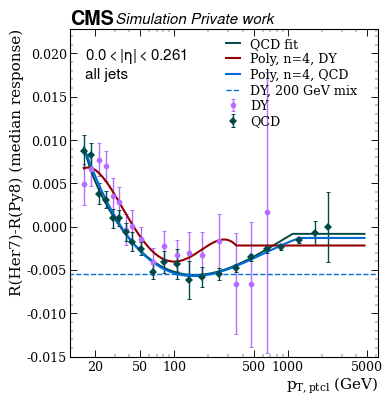

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_all_jets_eta0p261to0p522


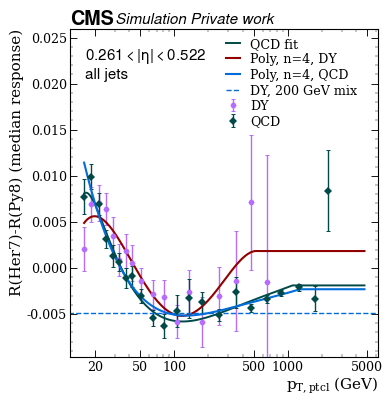

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_all_jets_eta0p522to0p783


In [ ]:
# if use_corrections == 'ratio': #combine_antiflavour:
# ratio_fits = {}
Her_Py_ratio_incl_DY = RatioPlotFitRes(binning=eta_binning, ptmin_global=ptmin_global, ptmax_global=ptmax_global)
Her_Py_ratio_incl_QCD = RatioPlotFitRes(binning=eta_binning, ptmin_global=ptmin_global, ptmax_global=ptmax_global)

# for flav in ['all']:
#     for flav in ['b']:
fit_res_tmp = np.array([plot_ratio_comparisons_samples('all', etaidx, jeteta_bins, pt_bins.centres, eta_binning_str,
                                                      evaluator=evaluator, evaluator_names=evaluator_names,
                                                      plotnewfit=True,
                                                      plotcorrectionratios=True,
                                                      show_original_uncertainties=True,
                                                      max_point_fit_idx=3,
                                                       inflate_smallest_std_bool=False,
                                                      denom_samples=['_DY-MG-Py', '_QCD-MG-Py'],
                                                      samples=['_DY-MG-Her', '_QCD-MG-Her'],
                                                      sample_lab=['DY', 'QCD'],
                                                       fit_simultaneously=False,
                                                      draw_DY200line=True,
                                                      plot_corr_fits={'J':'QCD'}) 
                            for etaidx in range(jeteta_bins.nbins)]) #
fit_res_1 = np.array([tmp[0] for tmp in fit_res_tmp])
fit_res_2 = np.array([tmp[1] for tmp in fit_res_tmp])
Her_Py_ratio_incl_DY.add_flavor('all', fit_res_1)
Her_Py_ratio_incl_QCD.add_flavor('all', fit_res_2)

In [ ]:
# # if use_corrections == 'ratio': #combine_antiflavour:
# ratio_fits = {}
# Her_Py_ratio_incl_QCD = RatioPlotFitRes(binning=eta_binning, ptmin_global=ptmin_global, ptmax_global=ptmax_global)
# # for flav in ['all']:
# #     for flav in ['b']:
# fit_res_tmp = np.array([plot_ratio_comparisons_samples('all', etaidx, jeteta_bins, pt_bins.centres, eta_binning_str,
#                                                       evaluator=evaluator, evaluator_names=evaluator_names,
#                                                       plotnewfit=True,
#                                                       plotcorrectionratios=True,
#                                                       show_original_uncertainties=True,
#                                                       max_point_fit_idx=3,
#                                                        inflate_smallest_std_bool=False,
#                                                       denom_samples=['_QCD-MG-Py'],
#                                                       samples=['_QCD-MG-Her'],
#                                                       sample_lab=['QCD'],
#                                                       plot_corr_fits={'J':'QCD'}) 
#                             for etaidx in range(jeteta_bins.nbins)]) #
# Her_Py_ratio_incl_QCD.add_flavor('all', fit_res_tmp)

In [ ]:
if use_corrections == 'ratio': #combine_antiflavour:
    ratio_fits = {}
    Her_Py_ratio_fit_res = RatioPlotFitRes(binning=eta_binning, ptmin_global=ptmin_global, ptmax_global=ptmax_global)
    for flav in flavors:
#     for flav in ['b']:
        fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx, jeteta_bins, pt_bins.centres, eta_binning_str,
                                                              evaluator=evaluator, evaluator_names=evaluator_names,
                                                              plotnewfit=True,
                                                              plotcorrectionratios=True,
                                                              show_original_uncertainties=True,
                                                              max_point_fit_idx=5) 
                                    for etaidx in range(jeteta_bins.nbins)]) #
        Her_Py_ratio_fit_res.add_flavor(flav, fit_res_tmp)

In [ ]:
# if use_corrections == 'ratio': #combine_antiflavour:
#     ratio_fits = {}
#     Her_Py_ratio_fit_res = RatioPlotFitRes(binning=eta_binning, ptmin_global=ptmin_global, ptmax_global=ptmax_global)
#     for flav in flavors:
# #     for flav in ['b']:
#         fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx, jeteta_bins, pt_bins.centres, eta_binning_str,
#                                                               evaluator=evaluator, evaluator_names=evaluator_names, plotsimfit=True) 
#                                     for etaidx in range(jeteta_bins.nbins)]) #range(2)]) #
#         Her_Py_ratio_fit_res.add_flavor(flav, fit_res_tmp)

### Read in the old Run1 flavor uncertainties to plot

In [ ]:
from coffea.lookup_tools import extractor
unc = ["* * Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_run2flavor.junc.txt"]
# unc = ["* * Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK4PFchs.junc.txt"]

ext = extractor()
ext.add_weight_sets(unc)
ext.finalize()
flav_evaluator = ext.make_evaluator()

lab_to_flav = {"DY" : "FlavorZJet",
               "QCD": "FlavorQCD",
               "GammaJet": "FlavorPhotonJet",
               "q":   "FlavorPureQuark",
               "c":   "FlavorPureCharm",
               "b":   "FlavorPureBottom",
               "g":   "FlavorPureGluon",
               }

# def get_uncertainties():
uncertainties = {key:flav_evaluator[f'Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_run2flavor_{lab_to_flav[key]}']
                   for key in lab_to_flav}
# uncertainties = {key:flav_evaluator[f'Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_{lab_to_flav[key]}']
#                    for key in lab_to_flav}

In [ ]:
# ptplot_vals = [16, 21.5, 32.5, 51, 105, 350, 650]
# # etaplot_vals = [2.8195-0.001] 
# etaplot_vals = jeteta_bins.centres #[16, 21.5, 32.5, 51, 105, 350, 650]


# # ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# # etaplot_vals = etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

# plot_vals = list(etaplot_vals)+ptplot_vals
# plotvspt_ls = len(etaplot_vals)*[True]+len(ptplot_vals)*[False]

# inverse = False
# divideHerPy = False #True
# plotvspt = True
# # use_corrections = 'ratio'  ## 'J' for QCD, 'T' for ttbar 'ratio' for the simultaneous fit of R(Herwig)-R(Pythia) -> not really a `ratio` but a difference, 'simfit' for the simfit of the corrections

# if use_corrections=='T':
#     pltstr2 = f'\nTTBAR fit'
# elif use_corrections=='J':
#     pltstr2 = '\nQCD fit'
# elif use_corrections=='ratio':
#     pltstr2 = '\nRatio simfit'
# elif use_corrections=='simfit':
#     pltstr2 = '\nCorrection simfit'
# else:
#     raise ValueError("wrong correction type provided")

# correction_txt_mtp = correction_txt
# use_corrections2 = 'S' if use_corrections=='simfit' else use_corrections
# if use_corrections=='ratio':
#     difference_evaluator = Her_Py_ratio_fit_res
# else:
#     difference_evaluator = CorrectionEvaluator(binning=eta_binning,
#                                         flavors=flavors,
#                                         correction_txt_dir=correction_txt_dir,
#                                         correction_txt=correction_txt_mtp,
#                                         inverse=False,
#                                         ptmin_global=ptmin_global,
#                                         ptmax_global=ptmax_global,
#                                         use_corrections=use_corrections2,
#                                        )

In [ ]:
#     pt_bins = PtBins("MC_truth")
#     one_spline = get_spline(np.array([1]*pt_bins.nbins), pt_bins)
#     zero_spline = get_spline(np.array([1e-15]*pt_bins.nbins), pt_bins)
#     eta_binning = qfrac_spline_dict['DY-MG-Her'].binning
#     flavors = qfrac_spline_dict['DY-MG-Her'].flavors
#     jeteta_bins = JetEtaBins(eta_binning, absolute=True)

In [ ]:
# evaluator = difference_evaluator
# for flav in evaluator.flavors:
#     fractions100_tmp = {flavii: np.array([zero_spline]*jeteta_bins.nbins) for flavii in flavors if not flav==flavii}
#     fractions100_tmp[flav] = np.array([one_spline]*jeteta_bins.nbins)
#     fractions100 = FlavorFractions(fractions100_tmp, eta_binning)

In [ ]:
# ptidx
# len(ptvals)

In [ ]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    res = ret[n - 1:] / n
    
    # Prepend smooth averages at the beginning
    prepend = [a[0]]
    for i in range(1, n//2):
        prepend.append(np.mean(a[:2*i+1]))
    
    # Append smooth averages at the end
    append = []
    for i in range(n//2, 1, -1):
        append.append(np.mean(a[-(2*i+1):]))
    return np.concatenate([prepend, res, append] )
    

In [ ]:
def make_ref(ptvals, etavals, Her_Py_ratio_incl_DY, Her_Py_ratio_incl_QCD):
    DY_0 = Her_Py_ratio_incl_DY.evaluate('all', etavals=0, ptvals=200)
    dijet_0 = Her_Py_ratio_incl_QCD.evaluate('all', [0]*len(ptvals), ptvals)
    dijet_eta = Her_Py_ratio_incl_QCD.evaluate('all', etavals, ptvals)
    return DY_0 + (dijet_0 - dijet_eta)

In [ ]:
# def convert_xpos(x, lims):
#     ax, bx = lims
#     return (np.log(x) - np.log(ax))/(np.log(bx) - np.log(ax))

# def convert_ypos(y, lims):
#     ay, by = lims
#     return (y - ay)/(by - ay)

In [ ]:
# from uncertainty_plotters import color_scheme
# from fileNames.available_datasets import legend_labels

# def convert_xpos(x, lims):
#     ax, bx = lims
#     return (np.log(x) - np.log(ax))/(np.log(bx) - np.log(ax))

# def convert_ypos(y, lims):
#     ay, by = lims
#     return (y - ay)/(by - ay)

# import matplotlib.patches as mpatches
# hep_label = "Private work"
# def plot_Rref(ptvals, Rdijet0, Rdijet, DY200, Rtot, Rtot_smooth, jeteta_bins, etaidx, pltstr, g_unc):
#     fix, ax = plt.subplots()
    
#     ax.plot(ptvals, Rdijet0, markersize=0, label=f"dijet, ${jeteta_bins.idx2plot_str(0)[5:]}",color=color_scheme["QCD"]['color'], linewidth=1)
#     ax.plot(ptvals, Rdijet, markersize=0, label=f"dijet, {jeteta_bins.idx2plot_str(etaidx)}",color=color_scheme["QCD"]['color'], linestyle='--')
#     ax.hlines(0, 1, 10000, linestyles='--', color='black',
#         linewidth=0.8, alpha=0.9)
#     ax.plot(ptvals, Rtot, markersize=0, label="$R_{ref}$")
#     ax.plot(ptvals, Rtot_smooth, markersize=0, label="$R_{ref}$ smoothed")
#     ax.plot(ptvals, g_unc, markersize=0, label="$R_{g, Her} - R_{g, Py}$", color=color_scheme["g"]['color'])
#     ax.plot(ptvals, g_unc-Rtot_smooth, markersize=0, label="g uncertainty", color=color_scheme["g"]['color'], linestyle='--')
#     ax.hlines(DY200, 1, 10000, linestyles='--',color=color_scheme["DY200"]['color'],
#         linewidth=1, alpha=0.9, label='DY at 200 GeV')
    
#     ax.set_xscale('log')
#     ax.set_xticks([10, 20, 50, 100, 500, 1000, 5000])
#     ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#     ax.set_xlim(15,1000)
#     ax.legend(handlelength=1.3)
#     ax.set_xlabel(r'$p_{T}$ (GeV)')
#     ax.set_ylabel('R(Her7) - R(Py8)')
#     hep.cms.label(hep_label, loc=0, data=False, ax=ax, rlabel='')
#     hep.label.exp_text(text=pltstr.replace("TTBAR", legend_labels["ttbar"]["lab"]), loc=2)
#     pltstr = pltstr.replace(', ', '_').replace(' ', '_').replace('$', '').replace('=', '_').replace('\eta', 'eta').replace('|', '').replace('<', '').replace('\n', '_')
#     figdir = f"fig/uncertainty/uncertainty_{pltstr}"
#     if not os.path.exists(figdir):
#         os.mkdir(figdir)
#     figdir = figdir+"/Rref"
#     if not os.path.exists(figdir):
#         os.mkdir(figdir)

#     ylim_old = ax.get_ylim()
#     ylim_pad = (ylim_old[1]-ylim_old[0])*0.2
#     ax.set_ylim(ylim_old[0],ylim_old[1]+ylim_pad)
#     fig_name = figdir+f"/Rref_{jeteta_bins.idx2str(etaidx)}"
#     print("Saving plot with the name = ", fig_name+".pdf / .png")
#     plt.savefig(fig_name+'.pdf')
#     plt.savefig(fig_name+'.png')
    
# #     ax.set_xlim(10,40)
# #     print("DY:", DY200)
# #     hax = plt.subplot(1,2,2)
# #     ax.set_position(good_pos)
# #     hax.set_position(good_pos)
# #     plt.annotate('', xy=(25, DY200[0]), xytext=(0, 5), 
# #             arrowprops=dict(facecolor='black', shrink=0.),
# #                 )
# #     np.searchsorted(30)
#     pt1_idx = np.searchsorted(ptvals, 35)
#     pt1 = ptvals[pt1_idx]
# #     Rtot_smooth
#     xarrow = convert_xpos(pt1, ax.get_xlim())
#     yarrow = convert_ypos(Rtot_smooth[pt1_idx], ax.get_ylim())
#     dyarrow = convert_ypos(0, ax.get_ylim()) - yarrow
#     mc = next(ax._get_lines.prop_cycler)
#     ax.arrow(xarrow, yarrow, 0, dyarrow, width=0.01, transform=ax.transAxes, length_includes_head=True, color=mc['color'])
    
#     yarrow2 = convert_ypos(g_unc[pt1_idx], ax.get_ylim())
#     dyarrow2 = convert_ypos((g_unc-Rtot_smooth)[pt1_idx], ax.get_ylim()) - yarrow2
#     ax.arrow(xarrow, yarrow2, 0, dyarrow2, width=0.01, transform=ax.transAxes, length_includes_head=True, color=mc['color'])

#     pt3_idx = np.searchsorted(ptvals, 20)
#     pt3 = ptvals[pt3_idx]
#     xarrow3 = convert_xpos(pt3, ax.get_xlim())
#     yarrow3 = convert_ypos(Rdijet0[pt3_idx], ax.get_ylim())
#     dyarrow3 = convert_ypos(Rdijet[pt3_idx], ax.get_ylim()) - yarrow3
#     mc = next(ax._get_lines.prop_cycler)
#     ax.arrow(xarrow3, yarrow3, 0, dyarrow3, width=0.007, transform=ax.transAxes, length_includes_head=True, color=mc['color'])

#     yarrow4 = convert_ypos(DY200[0], ax.get_ylim())
#     ax.arrow(xarrow3, yarrow4, 0, dyarrow3, width=0.007, transform=ax.transAxes, length_includes_head=True, color=mc['color'])
#     fig_name+='_arrows'
#     print("Saving plot with the name = ", fig_name+".pdf / .png")
#     plt.savefig(fig_name+'.pdf')
#     plt.savefig(fig_name+'.png')
#     #     hax.set_axis_off()
# #     plt.plot(25, DY200[0], 'ko', marker=r'$\downarrow$', markersize=20)
# #     arrow = mpatches.FancyArrow(0, 0, 2, 1,
# #                                  width=2, length_includes_head=True)
# #     ax.add_patch(arrow)
# #     ax.arrow(25, DY200[0], 0, -DY200[0], width = 2, length_includes_head=True, head_width = 1.2)

#     plt.show()

In [ ]:
from scipy.signal import savgol_filter

ptplot_vals = [16, 21.5, 32.5, 51, 105, 350, 650]
# ptplot_vals = []
# etaplot_vals = [2.8195-0.001] 
etaplot_vals = jeteta_bins.centres #[16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = [0]

# ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

plot_vals = list(etaplot_vals)+ptplot_vals
plotvspt_ls = len(etaplot_vals)*[True]+len(ptplot_vals)*[False]

inverse = False
divideHerPy = False #True
plotvspt = True
# use_corrections = 'ratio'  ## 'J' for QCD, 'T' for ttbar 'ratio' for the simultaneous fit of R(Herwig)-R(Pythia) -> not really a `ratio` but a difference, 'simfit' for the simfit of the corrections

if use_corrections=='T':
    pltstr2 = f'\nTTBAR fit'
elif use_corrections=='J':
    pltstr2 = '\nQCD fit'
elif use_corrections=='ratio':
    pltstr2 = '\nRatio simfit'
elif use_corrections=='simfit':
    pltstr2 = '\nCorrection simfit'
else:
    raise ValueError("wrong correction type provided")

correction_txt_mtp = correction_txt
use_corrections2 = 'S' if use_corrections=='simfit' else use_corrections
if use_corrections=='ratio':
    difference_evaluator = Her_Py_ratio_fit_res
else:
    difference_evaluator = CorrectionEvaluator(binning=eta_binning,
                                        flavors=flavors,
                                        correction_txt_dir=correction_txt_dir,
                                        correction_txt=correction_txt_mtp,
                                        inverse=False,
                                        ptmin_global=ptmin_global,
                                        ptmax_global=ptmax_global,
                                        use_corrections=use_corrections2,
                                       )
# uncert_to_save = {flav: np.array([None]*pt_bins_unc.nbins) for flav in flavors}        
for plot_val, plotvspt in zip(plot_vals, plotvspt_ls):
    if plotvspt:
        ptvals = np.geomspace(pt_bins.centres.min(), pt_bins.centres.max(), 2000)
        idx = jeteta_bins.get_bin_idx(plot_val)
        etavals = np.ones(len(ptvals))*jeteta_bins.centres[idx]
        pt_idxs = range(pt_bins.nbins)
        eta_idxs = idx
    else:    
        etavals = np.linspace(jeteta_bins.edges.min(),jeteta_bins.edges.max(), 200)
        idx = pt_bins.get_bin_idx(plot_val)
        ptvals = np.ones(len(etavals))*pt_bins.centres[idx]
        pt_idxs = idx
        eta_idxs = range(jeteta_bins.nbins)
    
    ptvals2= np.clip(ptvals, ptmin_global, ptmax_global)
    etaidx0=0 
    etavals0 = np.ones(len(ptvals2))*jeteta_bins.edges[etaidx0] ##Used to  obtain the eta dependance from dijet

    samples = ['QCD', 'DY', 'TTBAR']
    Her_samples = ['QCD-MG-Her', 'DY-MG-Her', 'Herwig-TTBAR']
    Py_samples = ['QCD-MG-Py', 'DY-MG-Py', 'Pythia-TTBAR']
    HerPy_differences = {}
    for ii in range(len(samples)):  
        sampHer = Her_samples[ii]
        sampPy = Py_samples[ii]
        samp = samples[ii]

        #remix to samples like QCD, DY, ttbar to check the consistency among the samples
        HerPy_spline = difference_evaluator.resum_ratio_to_mix(
                                          etavals, ptvals,
                                          qfrac_spline_dict[sampHer],
                                          qfrac_spline_dict[sampPy],
                                          divideHerPy
                                        )
        if not combine_antiflavour_txt:
            corr_all, corrstd_all = create_data_HerPy_differences(sampHer, sampPy, pt_idxs, eta_idxs,
                                                                  inverse=inverse, divideHerPy=divideHerPy,
                                                                  eta_binning_str=eta_binning_str+combine_antiflavour_txt)

            HerPy_differences[samp] = [HerPy_spline, corr_all, corrstd_all]
        else:
            HerPy_differences[samp] = [HerPy_spline, [0]*len(pt_idxs*eta_idxs), [0]*len(pt_idxs*eta_idxs)]


    uncertainty_curves = get_uncertainty(etavals, ptvals, etavals0,
                                                                      HerPy_differences['QCD'][0],
                                                                      evaluator=difference_evaluator,
                                                                      qfrac_spline_dict=qfrac_spline_dict,
                                                                     divideHerPy=divideHerPy)
    ptoretastr = jeteta_bins.idx2plot_str(idx) if plotvspt else f'$p_T$={str(pt_bins.centres[idx])} GeV'
    
#     uncertainty_curves['Rref'] = make_ref(ptvals, etavals, Her_Py_ratio_incl_DY, Her_Py_ratio_incl_QCD)
    if plotvspt:
#         uncertainty_curves['Rref'] = savgol_filter(uncertainty_curves['Rref'], 150, 3)
        Rinit = uncertainty_curves['Rref'].copy()
        uncertainty_curves['Rref'] = moving_average(uncertainty_curves['Rref'], len(uncertainty_curves['Rref'])//12)
    ptoretastr+=pltstr2
    
    if plotvspt:
        plot_Rref(ptvals, uncertainty_curves["Rdijet0"], HerPy_differences['QCD'][0], uncertainty_curves["g20q80_fixed"], 
                 Rinit, uncertainty_curves['Rref'], jeteta_bins, idx, pltstr2[1:], uncertainty_curves["g100"] )
        ptidx = np.searchsorted(ptvals,200) #DY never has decent stats
        HerPy_differences['DY'][0][ptidx:] = HerPy_differences['DY'][0][ptidx]
        flavors2 = ['g', 'c', 'b', 'q']
        plot_HerPydiff(ptvals, HerPy_differences, uncertainty_curves, divideHerPy, idx, jeteta_bins, pt_bins,
                       pltstr2, flavors2, combine_antiflavour=combine_antiflavour)
    
#     for flav in flavors:
#         if combine_antiflavour:
#             uncert_to_save[flav] = np.vstack([uncert_to_save[flav],
#                                               uncertainty_curves[flav+'100']-uncertainty_curves['Rref']])
#         else:
#             uncert_to_save[flav] = np.vstack([uncert_to_save[flav],
#                                               uncertainty_curves[flav+'100']])    
    
    if not divideHerPy:
        flavors2 = ['g', 'c', 'b', 'q', 'u', 'd', 's']
#         print("HerPy diff 1 = ", HerPy_differences['QCD'][0][:10]*100)
        if combine_antiflavour:
            plot_uncertainty(ptvals, etavals, HerPy_differences, uncertainty_curves, uncertainties,
                             ptoretastr, pltstr2, flavors2, plotvspt=plotvspt, plot_qcd_DY=True)
        else:
            plot_uncertainty_antiflav(ptvals, etavals, uncertainty_curves, uncertainties,
                             ptoretastr, flavors2, plotvspt=plotvspt)
# for flav in flavors:
#     uncert_to_save[flav] = uncert_to_save[flav][1:]

In [ ]:
# plot_uncertainty_antiflav(ptvals, etavals, uncertainty_curves, uncertainties,
#                              ptoretastr, flavors, plotvspt=plotvspt)

In [313]:
# ptplot_vals = [16, 21.5, 32.5, 51, 105, 350, 650]
# # etaplot_vals = [2.8195-0.001] 
# etaplot_vals = jeteta_bins.centres #[16, 21.5, 32.5, 51, 105, 350, 650]


# # ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# # etaplot_vals = etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

# plot_vals = list(etaplot_vals)+ptplot_vals
# plotvspt_ls = len(etaplot_vals)*[True]+len(ptplot_vals)*[False]

# inverse = False
# divideHerPy = False #True
# plotvspt = True
# use_corrections = 'simfit'  ## 'J' for QCD, 'T' for ttbar 'ratio' for the combined fit

# if use_corrections=='T':
#     pltstr2 = f'\nTTBAR fit'
# elif use_corrections=='J':
#     pltstr2 = '\nQCD fit'
# elif use_corrections=='ratio':
#     pltstr2 = '\nRatio simfit'
# elif use_corrections=='simfit':
#     pltstr2 = '\nCorrection simfit'
# else:
#     raise ValueError("wrong correction type provided")

# correction_txt_mtp = correction_txt_simfit if use_corrections=='simfit' else correction_txt
# use_corrections2 = 'J' if use_corrections=='simfit' else use_corrections
# if use_corrections=='ratio':
#     difference_evaluator = Her_Py_ratio_fit_res
# else:
#     difference_evaluator = CorrectionEvaluator(binning=eta_binning,
#                                         flavors=flavors,
#                                         correction_txt_dir=correction_txt_dir,
#                                         correction_txt=correction_txt_mtp,
#                                         inverse=False,
#                                         ptmin_global=ptmin_global,
#                                         ptmax_global=ptmax_global,
#                                         use_corrections=use_corrections2,
#                                        )
        
# for plot_val, plotvspt in zip(plot_vals, plotvspt_ls):
#     if plotvspt:
#         ptvals = np.geomspace(pt_bins.centres.min(), pt_bins.centres.max(), 10000)
#         idx = jeteta_bins.get_bin_idx(plot_val)
#         etavals = np.ones(len(ptvals))*jeteta_bins.centres[idx]
#         pt_idxs = range(pt_bins.nbins)
#         eta_idxs = idx
#     else:    
#         etavals = np.linspace(jeteta_bins.centres.min(),jeteta_bins.centres.max(), 10000)
#         idx = pt_bins.get_bin_idx(plot_val)
#         ptvals = np.ones(len(etavals))*pt_bins.centres[idx]
#         pt_idxs = idx
#         eta_idxs = range(jeteta_bins.nbins)
    
#     ptvals2= np.clip(ptvals, ptmin_global, ptmax_global)
#     etaidx0=0 
#     etavals0 = np.ones(len(ptvals2))*jeteta_bins.edges[etaidx0] ##Used to  obtain the eta dependance from dijet

#     samples = ['QCD', 'DY', 'TTBAR']
#     Her_samples = ['QCD-MG-Her', 'DY-MG-Her', 'Herwig-TTBAR']
#     Py_samples = ['QCD-MG-Py', 'DY-MG-Py', 'Pythia-TTBAR']
#     HerPy_differences = {}
#     for ii in range(len(samples)):  
#         sampHer = Her_samples[ii]
#         sampPy = Py_samples[ii]
#         samp = samples[ii]

#         HerPy_spline = difference_evaluator.resum_ratio_to_mix(
#                                           etavals, ptvals,
#                                           qfrac_spline_dict[sampHer],
#                                           qfrac_spline_dict[sampPy],
#                                           divideHerPy
#                                         )
#         if not combine_antiflavour_txt:
#             corr_all, corrstd_all = create_data_HerPy_differences(sampHer, sampPy, pt_idxs, eta_idxs,
#                                                                   inverse=inverse, divideHerPy=divideHerPy,
#                                                                   eta_binning_str=eta_binning_str+combine_antiflavour_txt)

#             HerPy_differences[samp] = [HerPy_spline, corr_all, corrstd_all]
#         else:
#             HerPy_differences[samp] = [HerPy_spline, [0]*len(pt_idxs*eta_idxs), [0]*len(pt_idxs*eta_idxs)]


#     additional_uncertainty_curves = get_uncertainty(etavals, ptvals, etavals0,
#                                                                       HerPy_differences['QCD'][0],
#                                                                       evaluator=difference_evaluator,
#                                                                       qfrac_spline_dict=qfrac_spline_dict,
#                                                                      divideHerPy=divideHerPy)
#     if plotvspt:
#         plot_HerPydiff(ptvals, HerPy_differences, additional_uncertainty_curves, divideHerPy, idx, jeteta_bins, pt_bins,
#                        pltstr2, flavors, combine_antiflavour=combine_antiflavour)
    
#     if not divideHerPy:
# #         print("HerPy diff 1 = ", HerPy_differences['QCD'][0][:10]*100)
#         ptoretastr = jeteta_bins.idx2plot_str(idx) if plotvspt else f'$p_T$={str(pt_bins.centres[idx])} GeV'
                
#         ptoretastr+=pltstr2
#         if combine_antiflavour:
#             plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, uncertainties,
#                              ptoretastr, flavors, plotvspt=plotvspt)
#         else:
#             plot_uncertainty_antiflav(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, uncertainties,
#                              ptoretastr, flavors, plotvspt=plotvspt)
        

In [366]:
# uncert_to_save

### Run in the bins of the uncertainty files

In [378]:
# jeteta_bins_unc = JetEtaBins("Uncert", absolute=True)
# pt_bins_unc = PtBins("Uncert")

jeteta_bins_unc = jeteta_bins
pt_bins_unc = pt_bins

# jeteta_bins_unc = JetEtaBins("HCalPart", absolute=True)
# pt_bins_unc = PtBins("MC_truth")

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta0p0to0p261.pdf / .png
Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta0p0to0p261_arrows.pdf / .png


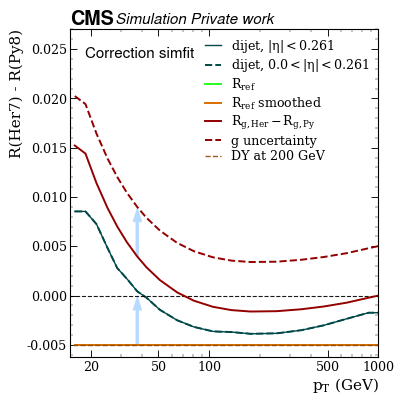

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Herwig_Pythia_difference//Herwig_Pythia_difference_Correction_simfit_eta0p0to0p261.pdf / .png


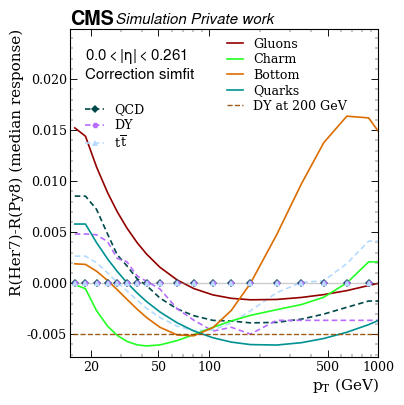

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/JECuncertainty_vs_pt_eta_00eta0261_Correction_simfit.pdf / .png


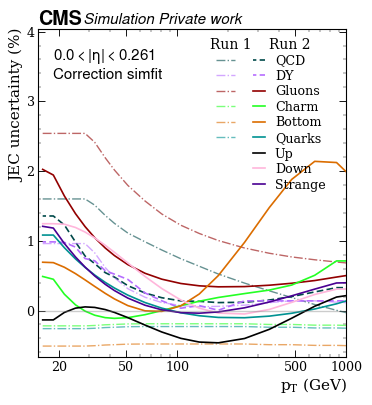

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta0p261to0p522.pdf / .png
Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta0p261to0p522_arrows.pdf / .png


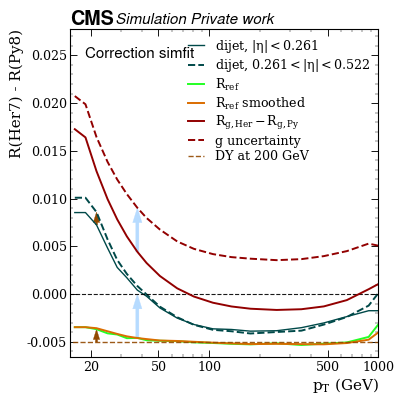

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Herwig_Pythia_difference//Herwig_Pythia_difference_Correction_simfit_eta0p261to0p522.pdf / .png


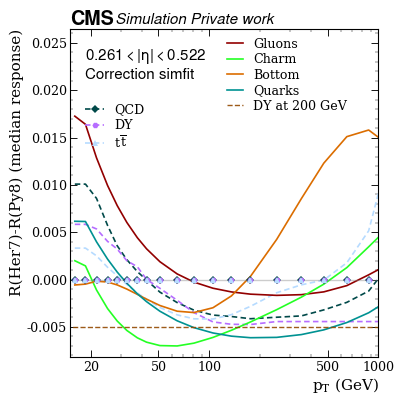

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/JECuncertainty_vs_pt_eta_0261eta0522_Correction_simfit.pdf / .png


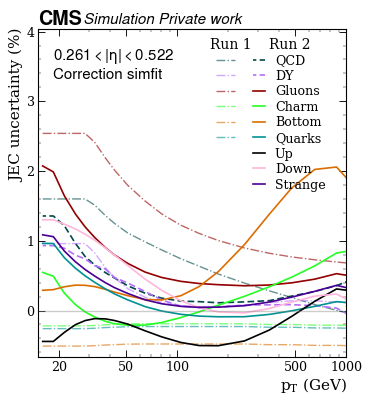

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta0p522to0p783.pdf / .png
Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta0p522to0p783_arrows.pdf / .png


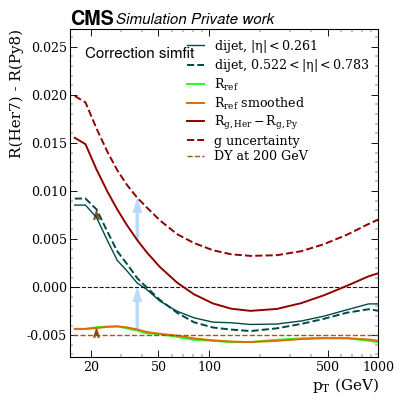

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Herwig_Pythia_difference//Herwig_Pythia_difference_Correction_simfit_eta0p522to0p783.pdf / .png


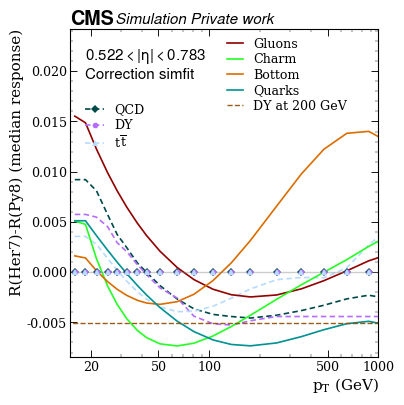

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/JECuncertainty_vs_pt_eta_0522eta0783_Correction_simfit.pdf / .png


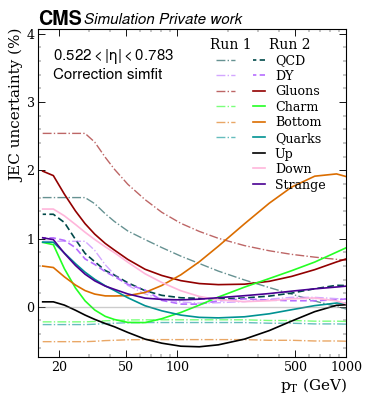

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta0p783to1p044.pdf / .png
Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta0p783to1p044_arrows.pdf / .png


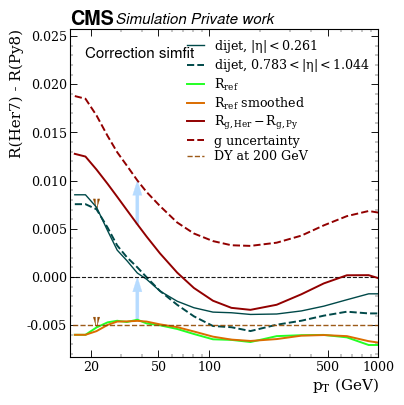

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Herwig_Pythia_difference//Herwig_Pythia_difference_Correction_simfit_eta0p783to1p044.pdf / .png


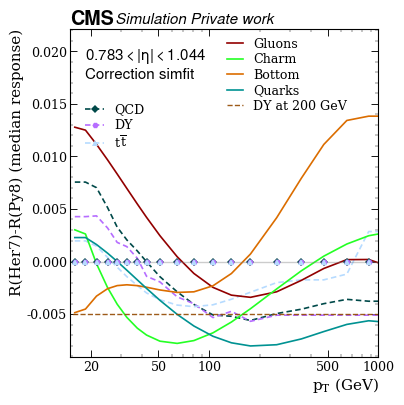

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/JECuncertainty_vs_pt_eta_0783eta1044_Correction_simfit.pdf / .png


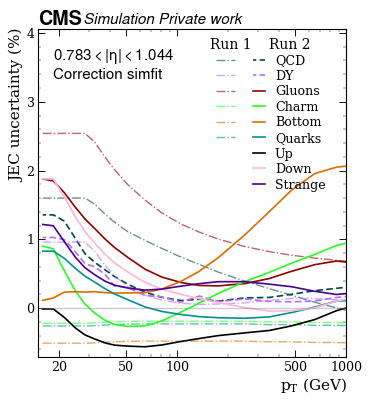

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta1p044to1p305.pdf / .png
Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta1p044to1p305_arrows.pdf / .png


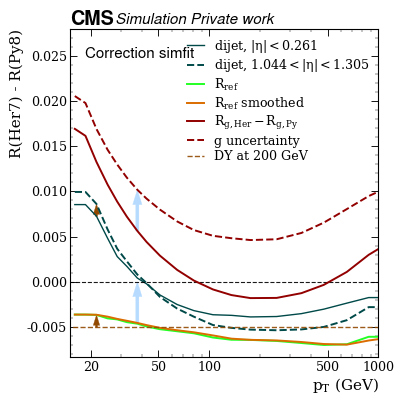

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Herwig_Pythia_difference//Herwig_Pythia_difference_Correction_simfit_eta1p044to1p305.pdf / .png


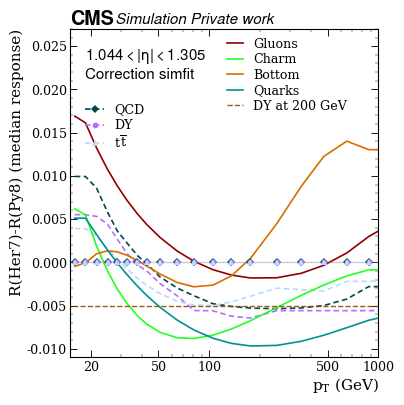

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/JECuncertainty_vs_pt_eta_1044eta1305_Correction_simfit.pdf / .png


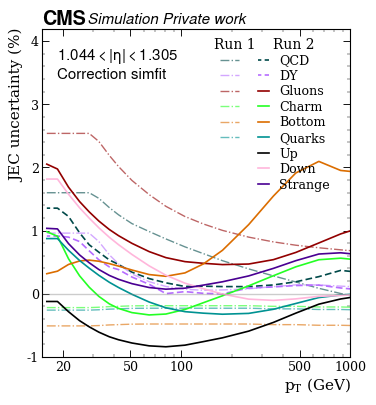

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta1p305to1p566.pdf / .png
Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta1p305to1p566_arrows.pdf / .png


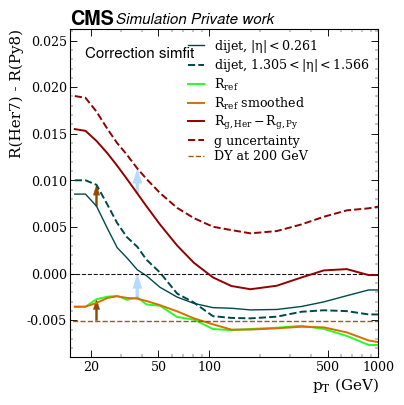

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Herwig_Pythia_difference//Herwig_Pythia_difference_Correction_simfit_eta1p305to1p566.pdf / .png


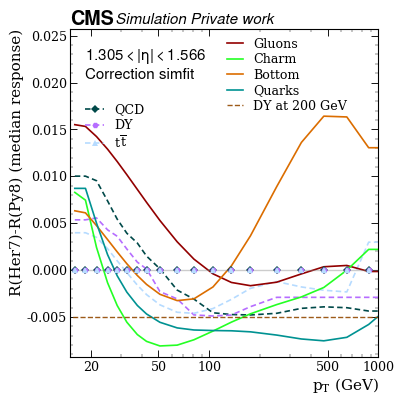

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/JECuncertainty_vs_pt_eta_1305eta1566_Correction_simfit.pdf / .png


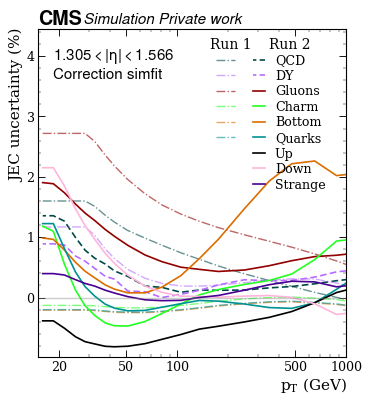

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta1p566to1p74.pdf / .png
Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta1p566to1p74_arrows.pdf / .png


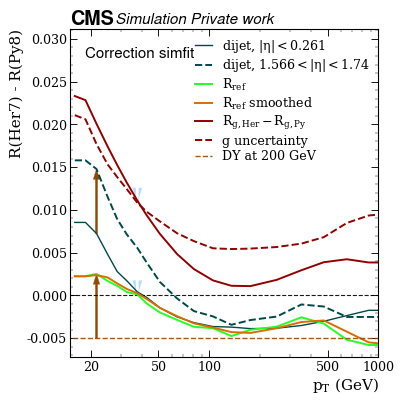

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Herwig_Pythia_difference//Herwig_Pythia_difference_Correction_simfit_eta1p566to1p74.pdf / .png


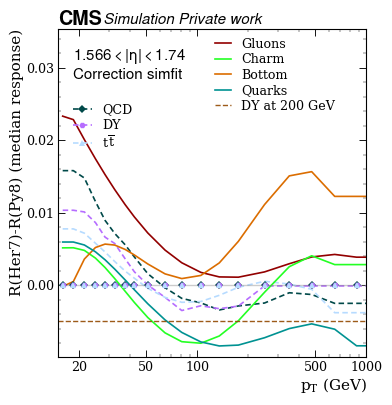

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/JECuncertainty_vs_pt_eta_1566eta174_Correction_simfit.pdf / .png


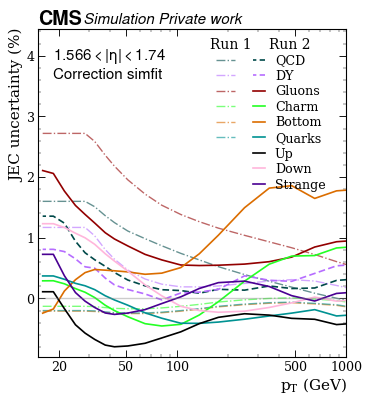

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta1p74to1p93.pdf / .png
Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta1p74to1p93_arrows.pdf / .png


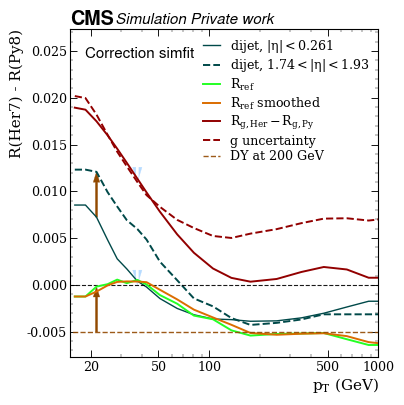

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Herwig_Pythia_difference//Herwig_Pythia_difference_Correction_simfit_eta1p74to1p93.pdf / .png


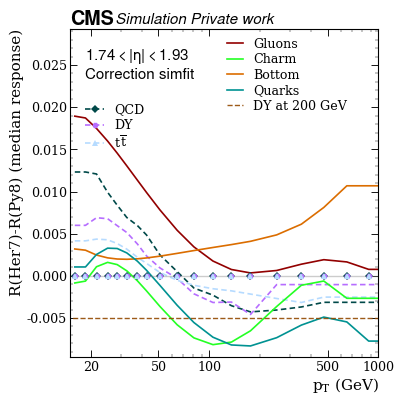

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/JECuncertainty_vs_pt_eta_174eta193_Correction_simfit.pdf / .png


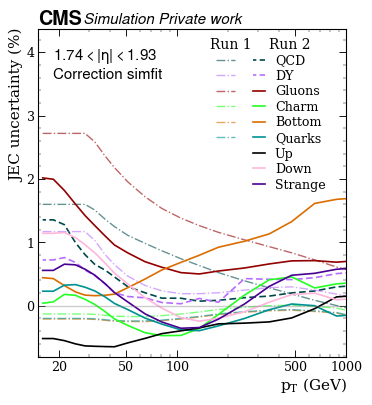

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta1p93to2p043.pdf / .png
Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta1p93to2p043_arrows.pdf / .png


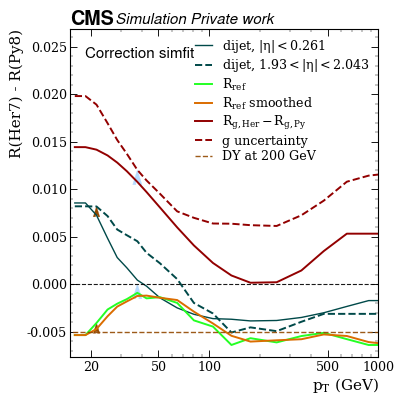

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Herwig_Pythia_difference//Herwig_Pythia_difference_Correction_simfit_eta1p93to2p043.pdf / .png


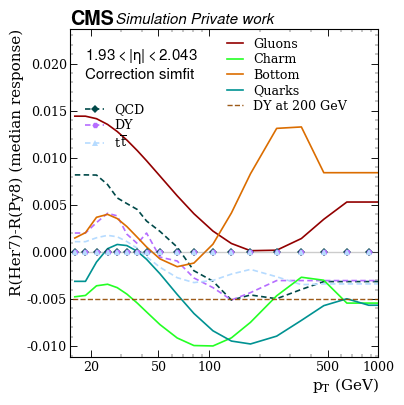

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/JECuncertainty_vs_pt_eta_193eta2043_Correction_simfit.pdf / .png


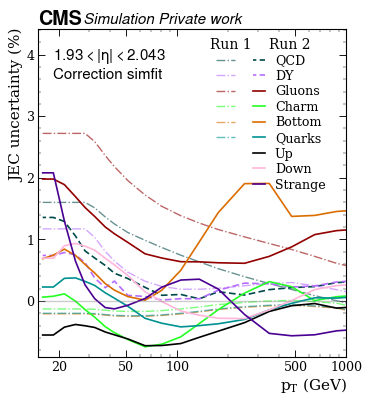

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta2p043to2p172.pdf / .png
Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta2p043to2p172_arrows.pdf / .png


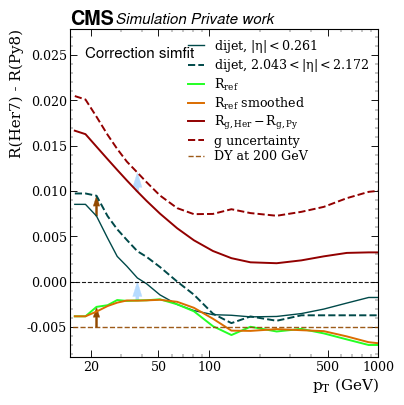

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Herwig_Pythia_difference//Herwig_Pythia_difference_Correction_simfit_eta2p043to2p172.pdf / .png


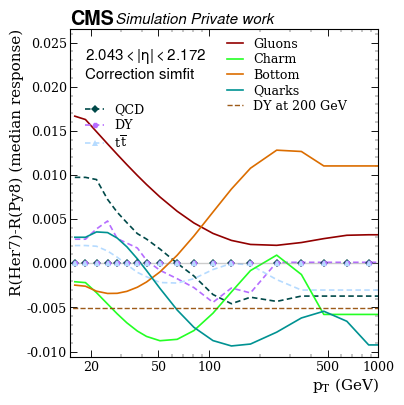

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/JECuncertainty_vs_pt_eta_2043eta2172_Correction_simfit.pdf / .png


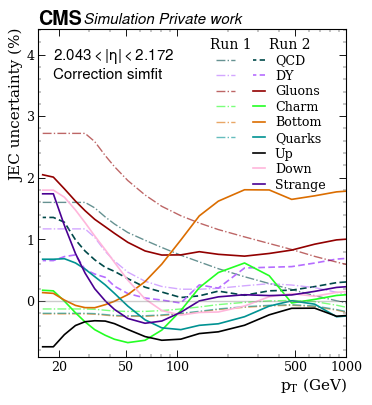

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta2p172to2p5.pdf / .png
Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta2p172to2p5_arrows.pdf / .png


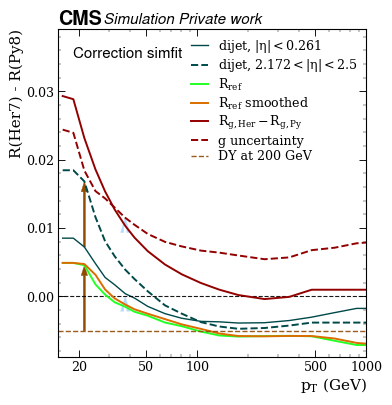

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Herwig_Pythia_difference//Herwig_Pythia_difference_Correction_simfit_eta2p172to2p5.pdf / .png


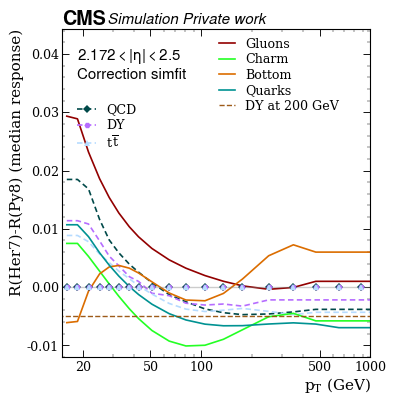

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/JECuncertainty_vs_pt_eta_2172eta25_Correction_simfit.pdf / .png


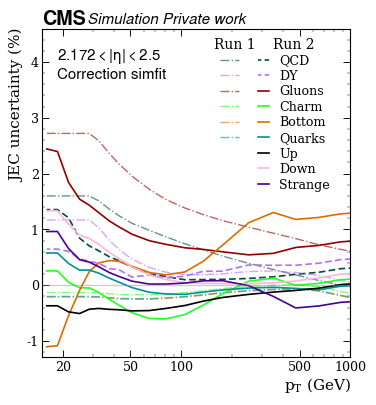

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta2p5to2p964.pdf / .png
Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta2p5to2p964_arrows.pdf / .png


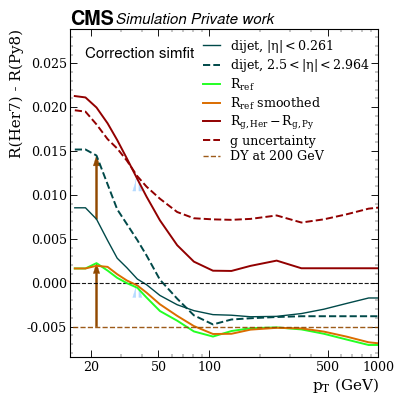

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Herwig_Pythia_difference//Herwig_Pythia_difference_Correction_simfit_eta2p5to2p964.pdf / .png


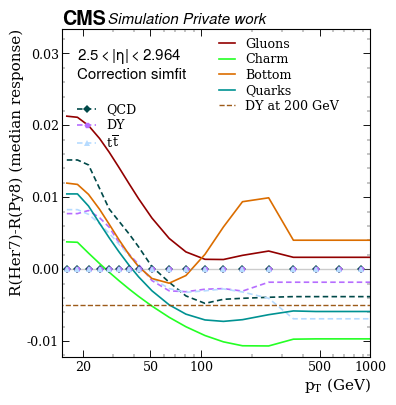

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/JECuncertainty_vs_pt_eta_25eta2964_Correction_simfit.pdf / .png


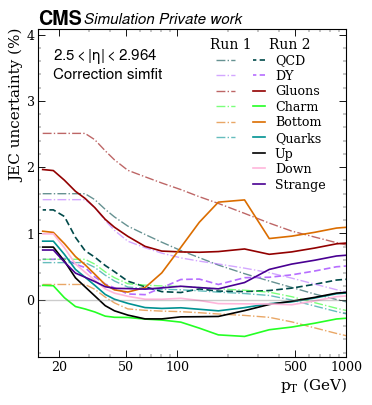

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta2p964to5p191.pdf / .png
Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Rref/Rref_eta2p964to5p191_arrows.pdf / .png


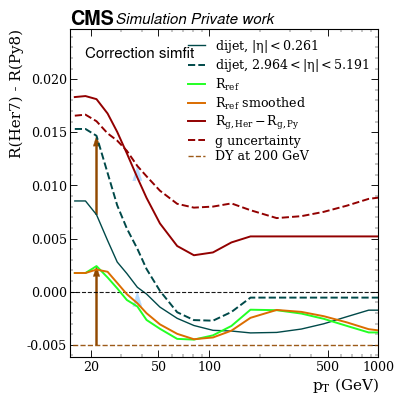

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/Herwig_Pythia_difference//Herwig_Pythia_difference_Correction_simfit_eta2p964to5p191.pdf / .png


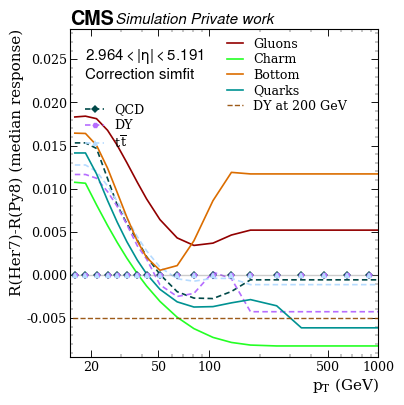

Saving plot with the name =  fig/uncertainty/uncertainty_Correction_simfit/JECuncertainty_vs_pt_eta_2964eta5191_Correction_simfit.pdf / .png


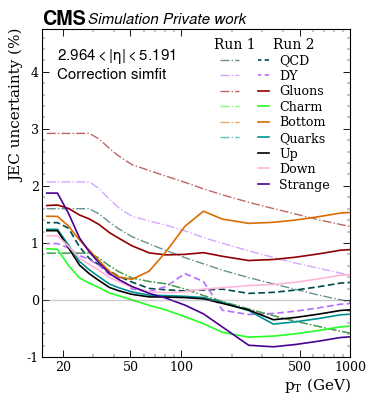

In [384]:
ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = [2.8195-0.001] 
etaplot_vals = jeteta_bins_unc.centres #[16, 21.5, 32.5, 51, 105, 350, 650]


# ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

plot_vals = list(etaplot_vals)

inverse = False
divideHerPy = False #True
plotvspt = True
# use_corrections = 'T'  ## 'J' for QCD, 'T' for ttbar 'ratio' for the combined fit

if use_corrections=='T':
    pltstr2 = f'\nTTBAR fit'
elif use_corrections=='J':
    pltstr2 = '\nQCD fit'
elif use_corrections=='ratio':
    pltstr2 = '\nRatio simfit'
elif use_corrections=='simfit':
    pltstr2 = '\nCorrection simfit'
else:
    raise ValueError("wrong correction type provided")

correction_txt_mtp = correction_txt
use_corrections2 = 'S' if use_corrections=='simfit' else use_corrections
if use_corrections=='ratio':
    difference_evaluator = Her_Py_ratio_fit_res
else:
    difference_evaluator = CorrectionEvaluator(binning=eta_binning,
                                        flavors=flavors,
                                        correction_txt_dir=correction_txt_dir,
                                        correction_txt=correction_txt_mtp,
                                        inverse=False,
                                        ptmin_global=ptmin_global,
                                        ptmax_global=ptmax_global,
                                        use_corrections=use_corrections2,
                                       )
    
uncert_to_save = {flav: np.array([None]*pt_bins_unc.nbins) for flav in flavors}
for plot_val in plot_vals:
    ptvals = pt_bins_unc.centres
    idx = jeteta_bins_unc.get_bin_idx(plot_val)
    etavals = np.ones(len(ptvals))*jeteta_bins_unc.centres[idx]
    pt_idxs = range(pt_bins_unc.nbins)
    eta_idxs = idx
#     else:    
#         etavals = np.linspace(jeteta_bins_unc.centres.min(),jeteta_bins_unc.centres.max(), 10000)
#         idx = pt_bins_unc.get_bin_idx(plot_val)
#         ptvals = np.ones(len(etavals))*pt_bins_unc.centres[idx]
#         pt_idxs = idx
#         eta_idxs = range(jeteta_bins_unc.nbins)
    
    ptvals2= np.clip(ptvals, ptmin_global, ptmax_global)
    etaidx0=0 
    etavals0 = np.ones(len(ptvals2))*jeteta_bins_unc.edges[etaidx0] ##Used to  obtain the eta dependance from dijet

    samples = ['QCD', 'DY', 'TTBAR']
    Her_samples = ['QCD-MG-Her', 'DY-MG-Her', 'Herwig-TTBAR']
    Py_samples = ['QCD-MG-Py', 'DY-MG-Py', 'Pythia-TTBAR']
    HerPy_differences = {}
    for ii in range(len(samples)):  
        sampHer = Her_samples[ii]
        sampPy = Py_samples[ii]
        samp = samples[ii]

        HerPy_spline = difference_evaluator.resum_ratio_to_mix(
                                          etavals, ptvals,
                                          qfrac_spline_dict[sampHer],
                                          qfrac_spline_dict[sampPy],
                                          divideHerPy
                                        )
        if not combine_antiflavour_txt:
#             corr_all, corrstd_all = create_data_HerPy_differences(sampHer, sampPy, pt_idxs, eta_idxs,
#                                                                   inverse=inverse, divideHerPy=divideHerPy,
#                                                                   eta_binning_str=eta_binning_str+combine_antiflavour_txt)

            HerPy_differences[samp] = [HerPy_spline, [0]*len(pt_idxs*eta_idxs), [0]*len(pt_idxs*eta_idxs)]
        else:
            HerPy_differences[samp] = [HerPy_spline, [0]*len(pt_idxs*eta_idxs), [0]*len(pt_idxs*eta_idxs)]


    uncertainty_curves = get_uncertainty(etavals, ptvals, etavals0,
                                                                      HerPy_differences['QCD'][0],
                                                                      evaluator=difference_evaluator,
                                                                      qfrac_spline_dict=qfrac_spline_dict,
                                                                     divideHerPy=divideHerPy)
    ptoretastr = jeteta_bins.idx2plot_str(idx) if plotvspt else f'$p_T$={str(pt_bins.centres[idx])} GeV'
    for flav in flavors:
        if combine_antiflavour:
            uncert_to_save[flav] = np.vstack([uncert_to_save[flav],
                                              uncertainty_curves[flav+'100']-uncertainty_curves['Rref']])
        else:
            uncert_to_save[flav] = np.vstack([uncert_to_save[flav],
                                              uncertainty_curves[flav+'100']])
#     uncertainty_curves['Rref'] = make_ref(ptvals, etavals, Her_Py_ratio_incl_DY, Her_Py_ratio_incl_QCD)
#     if plotvspt:
# #         uncertainty_curves['Rref'] = savgol_filter(uncertainty_curves['Rref'], 150, 3)
#         Rinit = uncertainty_curves['Rref'].copy()
#         uncertainty_curves['Rref'] = moving_average(uncertainty_curves['Rref'], len(uncertainty_curves['Rref'])//12)
#     ptoretastr+=pltstr2
    
#     if plotvspt:
#         plot_Rref(ptvals, uncertainty_curves["Rdijet0"], HerPy_differences['QCD'][0], uncertainty_curves["g20q80_fixed"], 
#                  Rinit, uncertainty_curves['Rref'], jeteta_bins, idx, pltstr2[1:], uncertainty_curves["g100"] )
#         ptidx = np.searchsorted(ptvals,200) #DY never has decent stats
#         HerPy_differences['DY'][0][ptidx:] = HerPy_differences['DY'][0][ptidx]
#         flavors2 = ['g', 'c', 'b', 'q']
#         plot_HerPydiff(ptvals, HerPy_differences, uncertainty_curves, divideHerPy, idx, jeteta_bins, pt_bins,
#                        pltstr2, flavors2, combine_antiflavour=combine_antiflavour)
    
#     if not divideHerPy:
#         flavors2 = ['g', 'c', 'b', 'q', 'u', 'd', 's']
# #         print("HerPy diff 1 = ", HerPy_differences['QCD'][0][:10]*100)
#         if combine_antiflavour:
#             plot_uncertainty(ptvals, etavals, HerPy_differences, uncertainty_curves, uncertainties,
#                              ptoretastr, pltstr2, flavors2, plotvspt=plotvspt, plot_qcd_DY=True)
#         else:
#             plot_uncertainty_antiflav(ptvals, etavals, uncertainty_curves, uncertainties,
#                              ptoretastr, flavors2, plotvspt=plotvspt)
for flav in flavors:
    uncert_to_save[flav] = uncert_to_save[flav][1:]

In [385]:
# ptplot_vals = [16, 21.5, 32.5, 51, 105, 350, 650]
# # ptplot_vals = []
# # etaplot_vals = [2.8195-0.001] 
# etaplot_vals = jeteta_bins.centres #[16, 21.5, 32.5, 51, 105, 350, 650]
# # etaplot_vals = [0]

# # ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# # etaplot_vals = etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

# plot_vals = list(etaplot_vals)+ptplot_vals
# plotvspt_ls = len(etaplot_vals)*[True]+len(ptplot_vals)*[False]

# inverse = False
# divideHerPy = False #True
# plotvspt = True
# # use_corrections = 'ratio'  ## 'J' for QCD, 'T' for ttbar 'ratio' for the simultaneous fit of R(Herwig)-R(Pythia) -> not really a `ratio` but a difference, 'simfit' for the simfit of the corrections

# if use_corrections=='T':
#     pltstr2 = f'\nTTBAR fit'
# elif use_corrections=='J':
#     pltstr2 = '\nQCD fit'
# elif use_corrections=='ratio':
#     pltstr2 = '\nRatio simfit'
# elif use_corrections=='simfit':
#     pltstr2 = '\nCorrection simfit'
# else:
#     raise ValueError("wrong correction type provided")

# correction_txt_mtp = correction_txt
# use_corrections2 = 'S' if use_corrections=='simfit' else use_corrections
# if use_corrections=='ratio':
#     difference_evaluator = Her_Py_ratio_fit_res
# else:
#     difference_evaluator = CorrectionEvaluator(binning=eta_binning,
#                                         flavors=flavors,
#                                         correction_txt_dir=correction_txt_dir,
#                                         correction_txt=correction_txt_mtp,
#                                         inverse=False,
#                                         ptmin_global=ptmin_global,
#                                         ptmax_global=ptmax_global,
#                                         use_corrections=use_corrections2,
#                                        )
        
# uncert_to_save = {flav: np.array([None]*pt_bins_unc.nbins) for flav in flavors}
# for plot_val, plotvspt in zip(plot_vals, plotvspt_ls):
#     if plotvspt:
#         ptvals = np.geomspace(pt_bins.centres.min(), pt_bins.centres.max(), 2000)
#         idx = jeteta_bins.get_bin_idx(plot_val)
#         etavals = np.ones(len(ptvals))*jeteta_bins.centres[idx]
#         pt_idxs = range(pt_bins.nbins)
#         eta_idxs = idx
#     else:    
#         etavals = np.linspace(jeteta_bins.edges.min(),jeteta_bins.edges.max(), 200)
#         idx = pt_bins.get_bin_idx(plot_val)
#         ptvals = np.ones(len(etavals))*pt_bins.centres[idx]
#         pt_idxs = idx
#         eta_idxs = range(jeteta_bins.nbins)
    
#     ptvals2= np.clip(ptvals, ptmin_global, ptmax_global)
#     etaidx0=0 
#     etavals0 = np.ones(len(ptvals2))*jeteta_bins.edges[etaidx0] ##Used to  obtain the eta dependance from dijet

#     samples = ['QCD', 'DY', 'TTBAR']
#     Her_samples = ['QCD-MG-Her', 'DY-MG-Her', 'Herwig-TTBAR']
#     Py_samples = ['QCD-MG-Py', 'DY-MG-Py', 'Pythia-TTBAR']
#     HerPy_differences = {}
#     for ii in range(len(samples)):  
#         sampHer = Her_samples[ii]
#         sampPy = Py_samples[ii]
#         samp = samples[ii]

#         #remix to samples like QCD, DY, ttbar to check the consistency among the samples
#         HerPy_spline = difference_evaluator.resum_ratio_to_mix(
#                                           etavals, ptvals,
#                                           qfrac_spline_dict[sampHer],
#                                           qfrac_spline_dict[sampPy],
#                                           divideHerPy
#                                         )
#         if not combine_antiflavour_txt:
#             corr_all, corrstd_all = create_data_HerPy_differences(sampHer, sampPy, pt_idxs, eta_idxs,
#                                                                   inverse=inverse, divideHerPy=divideHerPy,
#                                                                   eta_binning_str=eta_binning_str+combine_antiflavour_txt)

#             HerPy_differences[samp] = [HerPy_spline, corr_all, corrstd_all]
#         else:
#             HerPy_differences[samp] = [HerPy_spline, [0]*len(pt_idxs*eta_idxs), [0]*len(pt_idxs*eta_idxs)]


#     uncertainty_curves = get_uncertainty(etavals, ptvals, etavals0,
#                                                                       HerPy_differences['QCD'][0],
#                                                                       evaluator=difference_evaluator,
#                                                                       qfrac_spline_dict=qfrac_spline_dict,
#                                                                      divideHerPy=divideHerPy)
#     ptoretastr = jeteta_bins.idx2plot_str(idx) if plotvspt else f'$p_T$={str(pt_bins.centres[idx])} GeV'
    
# #     uncertainty_curves['Rref'] = make_ref(ptvals, etavals, Her_Py_ratio_incl_DY, Her_Py_ratio_incl_QCD)
#     if plotvspt:
# #         uncertainty_curves['Rref'] = savgol_filter(uncertainty_curves['Rref'], 150, 3)
#         Rinit = uncertainty_curves['Rref'].copy()
#         uncertainty_curves['Rref'] = moving_average(uncertainty_curves['Rref'], len(uncertainty_curves['Rref'])//12)
#     ptoretastr+=pltstr2
    
#     if plotvspt:
#         plot_Rref(ptvals, uncertainty_curves["Rdijet0"], HerPy_differences['QCD'][0], uncertainty_curves["g20q80_fixed"], 
#                  Rinit, uncertainty_curves['Rref'], jeteta_bins, idx, pltstr2[1:], uncertainty_curves["g100"] )
#         ptidx = np.searchsorted(ptvals,200) #DY never has decent stats
#         HerPy_differences['DY'][0][ptidx:] = HerPy_differences['DY'][0][ptidx]
#         flavors2 = ['g', 'c', 'b', 'q']
#         plot_HerPydiff(ptvals, HerPy_differences, uncertainty_curves, divideHerPy, idx, jeteta_bins, pt_bins,
#                        pltstr2, flavors2, combine_antiflavour=combine_antiflavour)
    
#     if not divideHerPy:
#         flavors2 = ['g', 'c', 'b', 'q', 'u', 'd', 's']
# #         print("HerPy diff 1 = ", HerPy_differences['QCD'][0][:10]*100)
#         if combine_antiflavour:
#             plot_uncertainty(ptvals, etavals, HerPy_differences, uncertainty_curves, uncertainties,
#                              ptoretastr, pltstr2, flavors2, plotvspt=plotvspt, plot_qcd_DY=True)
#         else:
#             plot_uncertainty_antiflav(ptvals, etavals, uncertainty_curves, uncertainties,
#                              ptoretastr, flavors2, plotvspt=plotvspt)


In [386]:
flavor_unc_name_dict = {'g': 'PureGluon', 'c': 'PureCharm', 'b':'PureBottom', 'ud':'PureUpDown',
                        'q':'PureQuark', 's':'PureStrange',
                        'u': 'PureUp', 'd': 'PureDown',
                        'cbar': 'PureAntiCharm', 'bbar':'PureAntiBottom', 'udbar':'PureAntiUpDown',
                        'qbar':'PureAntiQuark', 'sbar':'PureAntiStrange'}

In [387]:
# [jeteta_bins_unc.edges[0], jeteta_bins_unc.edges[1]]
new_uncertainties = {}
for flav in flavors:
    name = flavor_unc_name_dict[flav] 
    neg_etabins = [[-jeteta_bins_unc.edges[idx+1], -jeteta_bins_unc.edges[idx], pt_bins_unc.nbins*3] +
          list(np.column_stack((pt_bins_unc.centres, uncert_to_save[flav][idx], uncert_to_save[flav][idx])).reshape(-1))
    for idx in range(jeteta_bins_unc.nbins-1, -1, -1)]
    
    pos_etabins = [[jeteta_bins_unc.edges[idx], jeteta_bins_unc.edges[idx+1], pt_bins_unc.nbins*3] +
          list(np.column_stack((pt_bins_unc.centres, uncert_to_save[flav][idx], uncert_to_save[flav][idx])).reshape(-1))
    for idx in range(jeteta_bins_unc.nbins)]
    new_uncertainties ['Flavor'+name] = np.array(neg_etabins + pos_etabins)
    
    
    

In [395]:
round_int = 4 if combine_antiflavour else 6

def update_flavor_uncertainty_file(file_path, new_uncertainties):
    matched_section = False
    with open(file_path, 'r') as file:
        lines = file.readlines()

    output_lines = []
    i = 0
    while i < len(lines):
        line = lines[i]
        if line.startswith("["):
            section_title = line.strip()[1:-1]
            matched_section = section_title in new_uncertainties
            if matched_section:
                if 'PureQuark' in section_title and add_composed_flav:
                    new_section_titles = ["FlavorPureQuark", "FlavorPureUpDown", "FlavorPureStrange", "FlavorPureUp", "FlavorPureDown"]
                else:
                    new_section_titles = [section_title]
                for section_title in new_section_titles:
                    print('replacing or adding a new section secion:', section_title)
                    output_lines.append(f'[{section_title}]\n')
                    output_lines.append('{1 JetEta 1 JetPt "" Correction JECSource} \n')
                    values = new_uncertainties[section_title]
                    for value_row in values:
    #                     output_lines.append(value_row+'\n')
                        output_lines.append(' '.join(map(str, np.round(value_row, round_int))) + '\n')

    #                     output_lines.append('\n'.join(map(str, value_row)) + '\n')
                i += len(values)
            else:
                print('copying secion:', section_title)
                output_lines.append(line)
        elif not matched_section:
            output_lines.append(line)
        i += 1
    outfilename = file_path[:-4]+'_run2flavor.txt'
    print(f"Writing to a file '{outfilename}'")
    with open(outfilename, 'w') as file:
        file.writelines(output_lines)

In [396]:
def update_flavor_antiflavor_uncertainty_file(file_path, new_uncertainties):
    output_lines = []
    for section_title in new_uncertainties:
        output_lines.append(f'[{section_title}]\n')
        output_lines.append('{1 JetEta 1 JetPt "" Correction JECSource} \n')
        values = new_uncertainties[section_title]
        for value_row in values:
            output_lines.append(' '.join(map(str, np.round(value_row,round_int))) + '\n')

    outfilename = file_path[:-4]+'_run2flavor_antiflavor.txt'
    print(f"Writing to a file '{outfilename}'")
    with open(outfilename, 'w') as file:
        file.writelines(output_lines)

In [397]:
def scale_unc_file(file_path, flavor_to_replace='PureBottom', mult=-1, tag="_reverese_b"):
    ''' Reverse the variation for the bJEC and save to a separate file to be used for debugging of the bvsbbar JEC
    '''
    with open(file_path, 'r') as file:
        lines = file.readlines()

    output_lines = []
    matched_section = False
    for line in lines:
        if line.startswith("["):
            section_title = line.strip()[1:-1]
            if flavor_to_replace in section_title:
                output_lines.append(line)
                matched_section = True
            else:
                matched_section = False
        elif matched_section:
            if line.startswith("{"):
                output_lines.append(line)
            else:
                elements = line.split()
                updated_vars = [[float(elements[i]), mult*float(elements[i+1]), mult*float(elements[i+2])] for i in range(3, len(elements), 3)]
                updated_line = ' '.join(elements[:3]) + ' ' + ' '.join([f'{x[0]} {x[1]} {x[2]}' for x in updated_vars]) + ' \n'
                output_lines.append(updated_line)

    outfilename = file_path[:-4]+tag+'.txt'
#     return output_lines
    print(f"Writing to a file '{outfilename}'")
    with open(outfilename, 'w') as file:
        file.writelines(output_lines)
        
#     if not line[0] == '{' and not line[0] == '['
#     print(line)

In [398]:
if combine_antiflavour:
    update_flavor_uncertainty_file('Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK4PFchs.txt', new_uncertainties)
else:
    update_flavor_antiflavor_uncertainty_file('Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK4PFchs.txt', new_uncertainties)

copying secion: AbsoluteStat
copying secion: AbsoluteScale
copying secion: AbsoluteFlavMap
copying secion: AbsoluteMPFBias
copying secion: Fragmentation
copying secion: SinglePionECAL
copying secion: SinglePionHCAL
copying secion: FlavorQCD
copying secion: TimePtEta
copying secion: RelativeJEREC1
copying secion: RelativeJEREC2
copying secion: RelativeJERHF
copying secion: RelativePtBB
copying secion: RelativePtEC1
copying secion: RelativePtEC2
copying secion: RelativePtHF
copying secion: RelativeBal
copying secion: RelativeSample
copying secion: RelativeFSR
copying secion: RelativeStatFSR
copying secion: RelativeStatEC
copying secion: RelativeStatHF
copying secion: PileUpDataMC
copying secion: PileUpPtRef
copying secion: PileUpPtBB
copying secion: PileUpPtEC1
copying secion: PileUpPtEC2
copying secion: PileUpPtHF
copying secion: PileUpMuZero
copying secion: PileUpEnvelope
copying secion: SubTotalPileUp
copying secion: SubTotalRelative
copying secion: SubTotalPt
copying secion: SubTotal

In [ ]:
scale_unc_file('Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_run2flavor.txt' )

In [ ]:
scale_unc_file('Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_run2flavor_antiflavor.txt', flavor_to_replace='Pure', mult=20, tag="_x20" )